In [4]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
import seaborn as sn
import sklearn.metrics as metrics

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#importing dataset
activities=["climbingdown","climbingup","jumping","lying","running","sitting","standing","walking"]
location='/content/drive/MyDrive/Major_Project/clean_data.csv'
data=pd.read_csv(location)
data.drop(data.columns[[0]],axis=1,inplace=True)
(data.head())

,attr_time_gyro,attr_x_gyro,attr_y_gyro,attr_z_gyro,attr_time_acc,attr_x_acc,attr_y_acc,attr_z_acc,Activity,Label,Subject,Sample_Num
0,1435996982037,-0.815093,0.379639,0.408403,1435996982038,-0.217274,8.125920,1.502960,climbingdown,0,1,7
1,1435996982056,-0.977889,0.365895,0.438336,1435996982056,0.212485,8.208521,0.714071,climbingdown,0,1,7
2,1435996982076,-0.815704,0.554041,0.516832,1435996982077,0.249596,8.118139,-0.342969,climbingdown,0,1,7
3,1435996982095,-0.639164,0.823128,0.550735,1435996982095,0.270545,7.487866,0.112527,climbingdown,0,1,7
4,1435996982114,-0.506606,0.752267,0.589219,1435996982114,-0.014964,7.645285,0.856526,climbingdown,0,1,7


In [7]:
data.columns

Index(['attr_time_gyro', 'attr_x_gyro', 'attr_y_gyro', 'attr_z_gyro',
       'attr_time_acc', 'attr_x_acc', 'attr_y_acc', 'attr_z_acc', 'Activity',
       'Label', 'Subject', 'Sample_Num'],
      dtype='object')

In [8]:
def Range(a):
    return a.max()-a.min();

In [9]:
range_sample=data.groupby(['Activity','Subject','Sample_Num']).apply(Range).add_prefix('range_')
stdev_sample=data.groupby(['Activity','Subject','Sample_Num']).std().add_prefix('std_')
mean_sample=data.groupby(['Activity','Subject','Sample_Num']).mean().add_prefix('mean_')

In [10]:
mean_sample.head()

mean_attr_time_gyro  ...  mean_Label
Activity     Subject Sample_Num                       ...            
climbingdown 1       7                  1.435997e+12  ...         0.0
                     8                  1.435997e+12  ...         0.0
                     9                  1.435997e+12  ...         0.0
                     10                 1.435997e+12  ...         0.0
                     11                 1.435997e+12  ...         0.0

[5 rows x 9 columns]

In [11]:
total_data=pd.concat([stdev_sample,mean_sample,range_sample],axis=1)
total_data.reset_index(inplace=True)

In [12]:
total_data.head()

,Activity,Subject,Sample_Num,std_attr_time_gyro,std_attr_x_gyro,std_attr_y_gyro,std_attr_z_gyro,std_attr_time_acc,std_attr_x_acc,std_attr_y_acc,std_attr_z_acc,std_Label,mean_attr_time_gyro,mean_attr_x_gyro,mean_attr_y_gyro,mean_attr_z_gyro,mean_attr_time_acc,mean_attr_x_acc,mean_attr_y_acc,mean_attr_z_acc,mean_Label,range_attr_time_gyro,range_attr_x_gyro,range_attr_y_gyro,range_attr_z_gyro,range_attr_time_acc,range_attr_x_acc,range_attr_y_acc,range_attr_z_acc,range_Label
0,climbingdown,1,7,577.344583,0.786064,0.611101,0.402885,572.802628,1.028233,3.303459,1.968117,0.0,1.435997e+12,-0.233308,-0.028984,0.144039,1.435997e+12,0.533446,9.213110,2.375641,0.0,1978.0,3.587917,3.262326,1.893377,1977.0,5.589264,15.401898,11.406575,0.0
1,climbingdown,1,8,581.291714,0.942661,0.855090,0.374873,582.030385,1.470079,3.465349,2.752805,0.0,1.435997e+12,0.087604,-0.277429,0.141031,1.435997e+12,0.379439,9.024692,2.418964,0.0,1985.0,4.308738,5.279708,1.747991,1985.0,9.214684,15.316306,18.915391,0.0
2,climbingdown,1,9,579.635665,0.976116,0.803382,0.449999,579.373594,1.566840,3.024721,2.634441,0.0,1.435997e+12,-0.166086,-1.012663,-0.062882,1.435997e+12,0.155054,9.439451,1.640513,0.0,1981.0,4.679228,4.421137,2.178345,1982.0,7.890690,13.982736,21.457434,0.0
3,climbingdown,1,10,582.685275,0.995383,1.088734,0.458140,582.662663,2.012424,3.810429,2.944493,0.0,1.435997e+12,0.167801,-0.480547,0.051044,1.435997e+12,0.311127,8.968662,2.061090,0.0,2024.0,4.831944,7.441561,2.543032,2035.0,14.829087,15.386336,20.637421,0.0
4,climbingdown,1,11,580.331920,1.016299,1.113550,0.605436,581.116097,1.996506,3.389655,2.609269,0.0,1.435997e+12,-0.271014,-0.662130,-0.022941,1.435997e+12,0.001209,9.386025,1.909316,0.0,1959.0,4.633718,6.475477,2.649017,1969.0,11.089942,14.787786,16.913838,0.0


In [13]:
total_data.columns

Index(['Activity', 'Subject', 'Sample_Num', 'std_attr_time_gyro',
       'std_attr_x_gyro', 'std_attr_y_gyro', 'std_attr_z_gyro',
       'std_attr_time_acc', 'std_attr_x_acc', 'std_attr_y_acc',
       'std_attr_z_acc', 'std_Label', 'mean_attr_time_gyro',
       'mean_attr_x_gyro', 'mean_attr_y_gyro', 'mean_attr_z_gyro',
       'mean_attr_time_acc', 'mean_attr_x_acc', 'mean_attr_y_acc',
       'mean_attr_z_acc', 'mean_Label', 'range_attr_time_gyro',
       'range_attr_x_gyro', 'range_attr_y_gyro', 'range_attr_z_gyro',
       'range_attr_time_acc', 'range_attr_x_acc', 'range_attr_y_acc',
       'range_attr_z_acc', 'range_Label'],
      dtype='object')

In [14]:
total_data.Activity.value_counts()

walking         1906
standing        1905
sitting         1882
lying           1853
running         1799
climbingup      1758
climbingdown    1427
jumping          279
Name: Activity, dtype: int64

In [15]:
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion Matrix',cmap='YlOrRd'):
    plt.rcParams.update({'font.size': 11})
    plt.figure(figsize=(25,10),)
    plt.imshow( cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

In [16]:
def implement_model(model,title):
    model.fit(X_train,Y_train)
    Y_predicted_train=model.predict(X_train)
    Y_predicted_validate=model.predict(X_validate)
    Y_predicted_final=model.predict(X_final)
    print(f'Training F1 score is: {f1_score(Y_train,Y_predicted_train,average="macro"):.3f}')
    print(f'Validation F1 score is: {f1_score(Y_validate,Y_predicted_validate,average="macro"):.3f}')
    print(f'Testing F1 score is: {f1_score(Y_final,Y_predicted_final,average="macro"):.3f}')
    print(f'Training Accuracy is: {accuracy_score(Y_train,Y_predicted_train):.3f}')
    print(f'Validation Accuracy is: {accuracy_score(Y_validate,Y_predicted_validate):.3f}')
    print(f'Testing Accuracy is: {accuracy_score(Y_final,Y_predicted_final):.3f}')
    cm=confusion_matrix(Y_validate,Y_predicted_validate)
    array=cm
    df_cm = pd.DataFrame(array, index = [i for i in activities],
                  columns = [i for i in activities])
    plt.figure(figsize = (15,15))
    plt.title("VALIDATION CONFUSION MATRIX")
    sn.heatmap(df_cm, annot=True,fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();
    cm=confusion_matrix(Y_final,Y_predicted_final)
    array=cm
    df_cm = pd.DataFrame(array, index = [i for i in activities],
                  columns = [i for i in activities])
    plt.figure(figsize = (15,15))
    plt.title("TEST CONFUSION MATRIX")
    sn.heatmap(df_cm, annot=True,fmt="d")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout();

In [17]:
columns=[
       'std_attr_x_gyro', 'std_attr_y_gyro', 'std_attr_z_gyro',
         'std_attr_x_acc', 'std_attr_y_acc', 'std_attr_z_acc', 
         'mean_attr_x_gyro', 'mean_attr_y_gyro', 'mean_attr_z_gyro', 
         'mean_attr_x_acc', 'mean_attr_y_acc', 'mean_attr_z_acc',
         'range_attr_x_gyro', 'range_attr_y_gyro','range_attr_z_gyro', 
         'range_attr_x_acc', 'range_attr_y_acc', 'range_attr_z_acc']

In [18]:
train_temp=total_data.Subject<=3
validate_temp=total_data.Subject==4
test_temp=total_data.Subject>=5
X_final=total_data[columns][test_temp]
Y_final=total_data.Activity[test_temp]
X_train=total_data[columns][train_temp]
X_validate=total_data[columns][validate_temp]
Y_train=total_data.Activity[train_temp]
Y_validate=total_data.Activity[validate_temp]

In [19]:
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_validate=scaler.fit_transform(X_validate)
X_final = scaler.transform(X_final)
print('X_train->',X_train.shape)
print('X_validate->',X_validate.shape)
print('X_final->',X_final.shape)

X_train-> (6386, 18)
X_validate-> (2211, 18)
X_final-> (4212, 18)


In [20]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [21]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt',1,2,3,4,5,6,7,8,9,10]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 2000, num = 220)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
max_samples=[float(x) for x in np.linspace(start = 0.1, stop = 10, num = 100)]
max_leaf_nodes=[int(x) for x in np.linspace(start = 1, stop = 100, num = 100)]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'max_samples':max_samples,
               'max_leaf_nodes':max_leaf_nodes
               }
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10,
               19,
               28,
               37,
               46,
               55,
               64,
               73,
               82,
               91,
               100,
               109,
               119,
               128,
               137,
               146,
               155,
               164,
               173,
               182,
               191,
               200,
               209,
               218,
               228,
               237,
               246,
               255,
               264,
               273,
               282,
               291,
               300,
               309,
               318,
               328,
               337,
               346,
               355,
               364,
               373,
               382,
               391,
               400,
               409,
               418,
               427,
               437,
               446,
 

In [22]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 500, cv = 3, verbose=5, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,Y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 202 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 438 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 748 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1089 tasks      | elapsed: 22.8min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 29.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [23]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 364,
 'max_features': 'sqrt',
 'max_leaf_nodes': 71,
 'max_samples': 0.6,
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 380}

Training F1 score is: 0.999
Validation F1 score is: 0.436
Testing F1 score is: 0.453
Training Accuracy is: 0.999
Validation Accuracy is: 0.518
Testing Accuracy is: 0.504


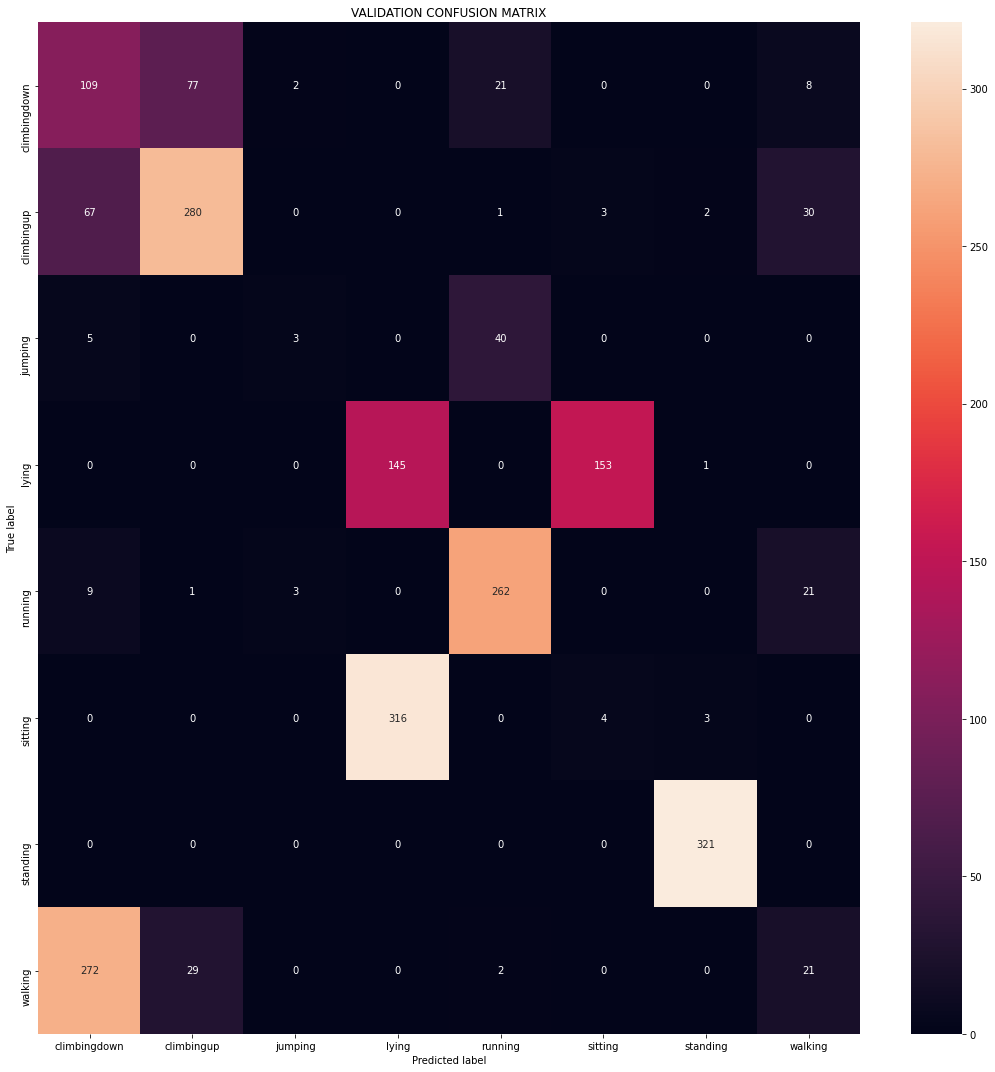

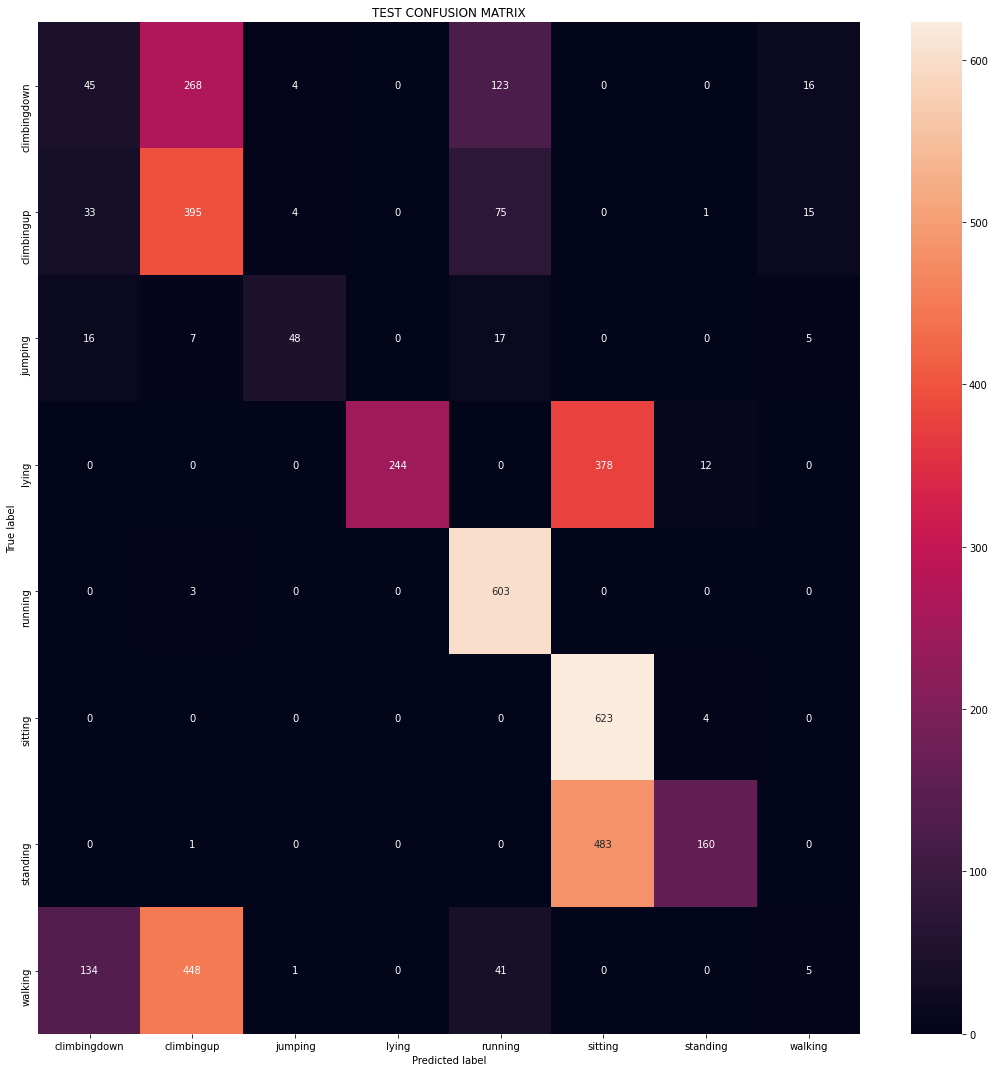

In [24]:
base_model = RandomForestClassifier(n_estimators = 11, random_state = 42)
implement_model(base_model,'base')

Training F1 score is: 0.980
Validation F1 score is: 0.438
Testing F1 score is: 0.465
Training Accuracy is: 0.979
Validation Accuracy is: 0.518
Testing Accuracy is: 0.557


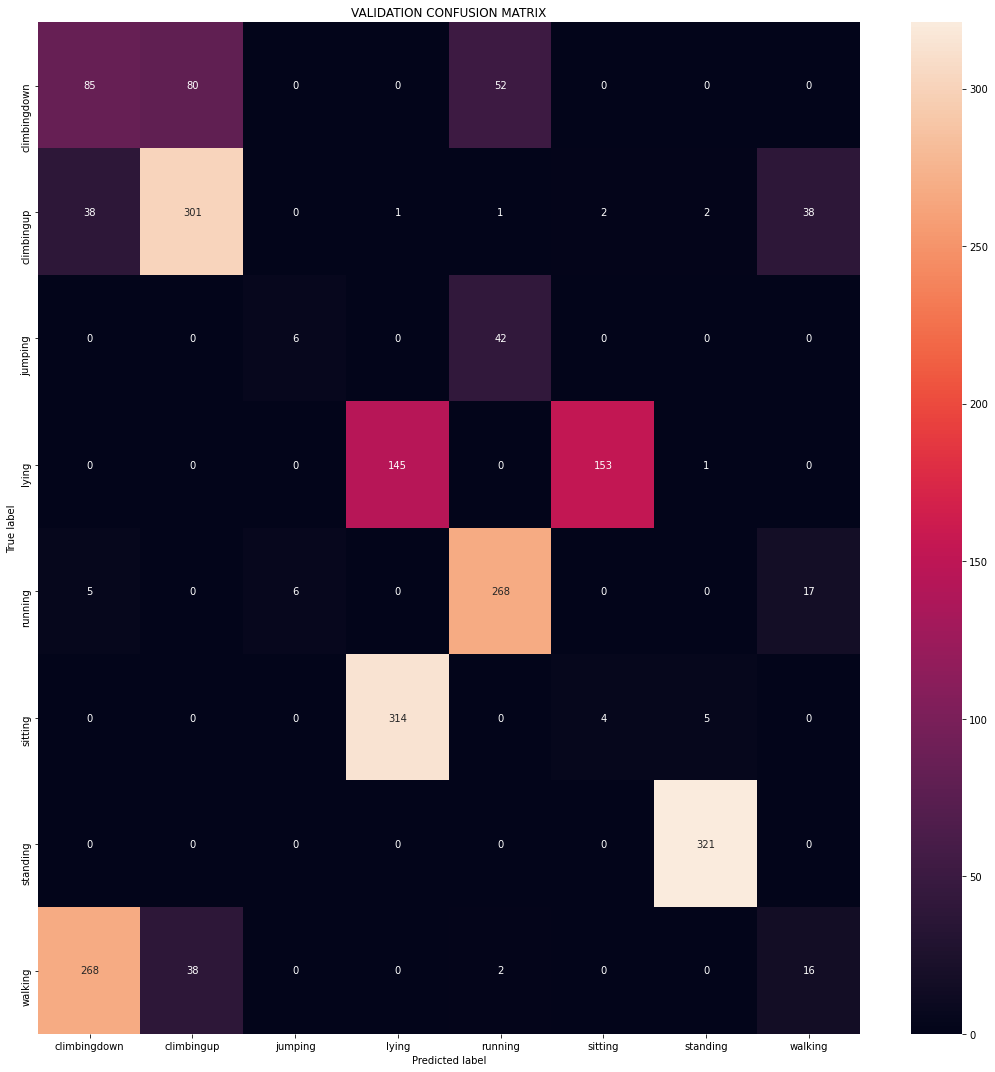

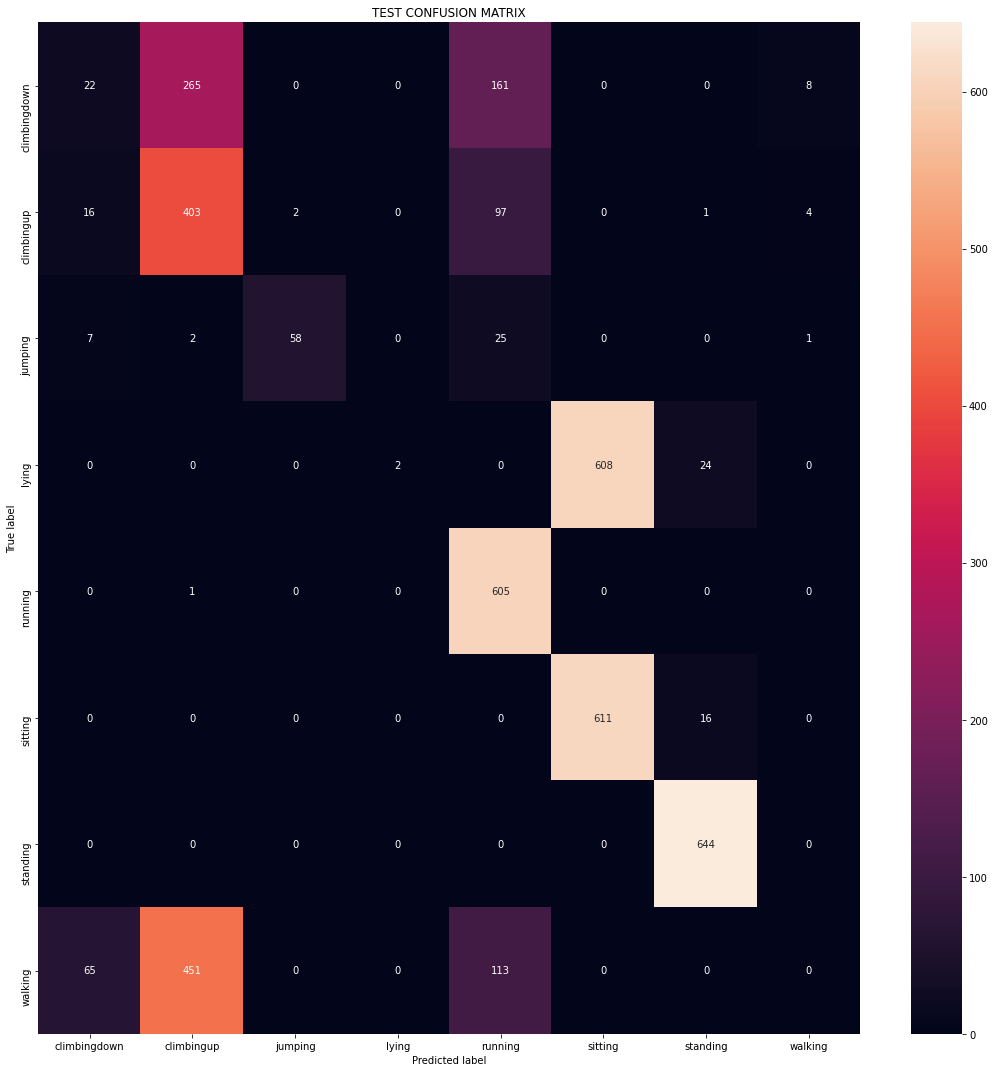

In [25]:
final_model =  rf_random.best_estimator_
implement_model(final_model,'final')